# Social Graphs 2021 - Assignment 2
Welcome to our exercise 2! Hope you enyoy the read, see you on the other side 😊

In [1]:
# Imports
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np

import wordcloud
import nltk
import networkx as nx
import community

import re
import json
import urllib
import requests
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import seaborn as sns
import os
from tqdm.notebook import tqdm
from IPython.display import display

import powerlaw
from fa2 import ForceAtlas2

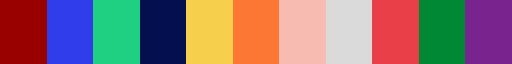

In [2]:
# Styles and data. If this cell block is not already hidden/minimized, feel free to do so, as it only contains the styles for the plots.
DTU_COLORS_HEX = dict(
    dtured      = "#990000",
    blue        = "#2F3EEA",
    brightgreen = "#1FD082",
    navyblue    = "#030F4F",
    yellow      = "#F6D04D",
    orange      = "#FC7634",
    pink        = "#F7BBB1",
    grey        = "#DADADA",
    red         = "#E83F48",
    green       = "#008835",
    purple      = "#79238E"
)

sns.set()
#sns.set_palette("Spectral")

cmap = sns.color_palette("Spectral", as_cmap=True)
cmap = ListedColormap(DTU_COLORS_HEX.values())

plt.rcParams["image.cmap"] = "Set1"

big_plot = dict(
    figsize     = (20, 20),
)

default = dict(
    figsize     = (20, 5),
)

ListedColormap(DTU_COLORS_HEX.values())

# 0. Building the network
This part will explain the strategy and regular expressions for each task: Downloading, finding gender and race and extracting links to characters.

## Strategy for extracting hyperlinks from the wiki-pages
### Downloading
First, we download the three wiki pages containing the ally, enemy and boss characters. From this, we use a regular expression to find all character names.
### Regex
First, the boss page has an edge case, where the boss's location is included in the same format as the name of the boss. To remove this, we use ```{{Small.*?''}}``` to find the locations and remove them.

When these are removed we use ```({{Term\|BotW\|(.*?)\|link[\|]*.*?}})``` to find the names of each character. All names follow the same convention of `{{Term|BotW|NAME OF CHARACTER|link|MAYBE MORE STUFF}}` occasionally followed by further information. This is solved by using `*.*?`, which lazily finds additional terms. `*?` makes sure that this is only done until the following character `}` is found.

## Strategy for finding gender and race
### Downloading
From the character names found in the previous step, we now download the content of each character using the API.

From this, we do two regular expressions to find race and gender.

### Regex
* Race: `{{Infobox.*?\|(?:race=|species=)\s(.*?)(?:\n|<ref).*?(?:\|gender=\s`**(.*?)**`(?:\n|<ref)|).*?}}`. 

For each character page, we use this expression. All meta information, including the races, is contained in an Infobox, explaining the beginning and end of the expressions. We use capture groups to allow for or-statements signified by `(|)` the |-symbol, as this cannot be written outside a capture group. Whether the keyword is `race` or `species` is not essential. `(?:)` is used to make the capture group not return anything. The same convention is followed throughout the expression to include different types of definitions. Lastly, the small group `(.*?)` is used to find the character's race. Characters might have multiple races, in which case only the first is chosen.

* Gender: `.*(Male|Female).*`. 

Genders are only included inside of infoboxes, which we found in the previous expression. Using the extraction of the prior expression, this expression is now used. This expression is only run for these infoboxes. The expression is only used on these, searching for males or females, where the `|`-symbol signifies an or-statement. For genders outside of male or female, the gender `unknown` is assigned to the character. 

## Strategy for extracting links to characters
Using the content of each character page, we now find the links. The code for finding the links can be in the following code block. 

### Regex
The links we observed came in two flavours: curly and square brackets, following slightly different conventions.

* Square brackets: `\[\[`**(.*?)**`(?:\|.*?|\#.*?)?\]\]`

All square bracket links are enclosed in double square brackets (`[[.*]]`). From inside, we find the actual link; the bold-fonted expression `(.*?)`. This lazily reads all information until it encounters a vertical line (`|`) or the closing square bracket `]`.

* Curly brackets: `{{(?:Term|Plural)\|.*?\|`**(.*?)**`(?:\|.*?)?}}`

All curly bracket links are also using double curly brackets (`{{.*}}`). Indifference to the square brackets, this is followed by either "Term" or "Plural", found and filtered out using `(?:Term|Plural)`. Otherwise, the links follow the same convention as the square brackets, and the capture group highlighted in bold is the expression used to find the link.

# 1. Network visualization and basic stats

## Preliminary
The code below finds the character links using the regex expressions previosly discussed, and extracts the giant component using networkx.

In [3]:
df = pd.read_csv("Characters.csv")
import networkx as nx

G = nx.DiGraph()
for _, (name, role, race, gender) in df.iterrows():
    G.add_node(name, role=role, race=race, gender=gender)

# Expressions
brackets_pattern = r'\[\[(.*?)(?:\|.*?|\#.*?)?\]\]'
curly_pattern =    r'{{(?:Term|Plural)\|.*?\|(.*?)(?:\|.*?)?}}'

for name in df.Name:
    description = open(f"././Characters/{name}.txt", "r", encoding="utf-8").read()
    links = []
    links.extend(re.findall(brackets_pattern, description))
    links.extend(re.findall(curly_pattern, description))
    for link in links:
        if link in df.Name.values and link != name:
            G.add_edge(name, link)

GCC = G.subgraph(max(nx.weakly_connected_components(G), key=len))

## Showing stats for the giant component of the network

In [4]:
print(f"Number of nodes in network: \t {GCC.number_of_nodes()}")
print(f"Number of links🔗: \t\t {GCC.number_of_edges()}")

sorted_in  = sorted(GCC.nodes, key=GCC.in_degree, reverse=True)
sorted_out = sorted(GCC.nodes, key=GCC.out_degree, reverse=True)
sorted_tot = sorted(GCC.nodes, key=GCC.degree, reverse=True)

print(f"Most connected in:\t {sorted_in[0]}\n\tin👈:\t{GCC.in_degree(sorted_in[0])}\n\tout👉:\t{GCC.out_degree(sorted_in[0])}")
print(f"Most connected out:\t {sorted_out[0]}\n\tin👈:\t{GCC.in_degree(sorted_out[0])}\n\tout👉:\t{GCC.out_degree(sorted_out[0])}")
print(f"Most connected overall:\t {sorted_tot[0]}\n\tin👈:\t{GCC.in_degree(sorted_tot[0])}\n\tout👉:\t{GCC.out_degree(sorted_tot[0])}")

allies = df[df.Role=="Ally"].Name.to_list()
enemies = df[df.Role.isin(["Enemy", "Boss"])].Name.to_list()

sorted_allies = list(filter(lambda x: x in allies, sorted_tot))
sorted_enemies = list(filter(lambda x: x in enemies, sorted_tot))

# Seems a bit long to show same result as above for all allies and enemies,
# so here we only look at total degree
print("Most connected allies ✌ (name, in, out) ")
print("\t"+"\n\t".join([", ".join([str(x), str(GCC.in_degree(x)), str(GCC.out_degree(x))]) for x in sorted_allies[:5]]))
print("Most connected enemies 😈 (name, in, out) ")
print("\t"+"\n\t".join([", ".join([str(x), str(GCC.in_degree(x)), str(GCC.out_degree(x))]) for x in sorted_enemies[:5]]))


Number of nodes in network: 	 520
Number of links🔗: 		 1741
Most connected in:	 Link
	in👈:	391
	out👉:	9
Most connected out:	 Traysi
	in👈:	2
	out👉:	14
Most connected overall:	 Link
	in👈:	391
	out👉:	9
Most connected allies ✌ (name, in, out) 
	Link, 391, 9
	Hylia, 67, 3
	Princess Zelda, 32, 7
	Riju, 23, 5
	Purah, 17, 8
Most connected enemies 😈 (name, in, out) 
	Calamity Ganon, 101, 8
	Bokoblin, 20, 10
	Lizalfos, 11, 13
	Moblin, 10, 12
	Stalizalfos, 9, 12


# Exercise 1a

## Stats
The number of nodes and links can be seen above.

## Most connected character.
Link being the most connected character is not surprising, as he is the franchise's main character. However, it surprised us a bit that he is not the most out-wards connected character, and Traysi is instead. After reading about her, it makes sense, as she has a quest where Link has to talk to different people, and all of these people are all linked on her page, which is of course not mentioned on Links page as it is quite a small quest, but all of it is mentioned on her page, as that is most of her role in the game.

## Most(ly) connected allies and enemies
It is more or less what was expected for the allies, as all the characters that appear in the top 5 are main characters. For the enemies, it's a bit confusing, as all other characters than Calamity Ganon are not characters but generic enemies. However, it does make sense that they are in the top 5, as they are commonly occurring.

## Plot of the in- and out-degree distribution

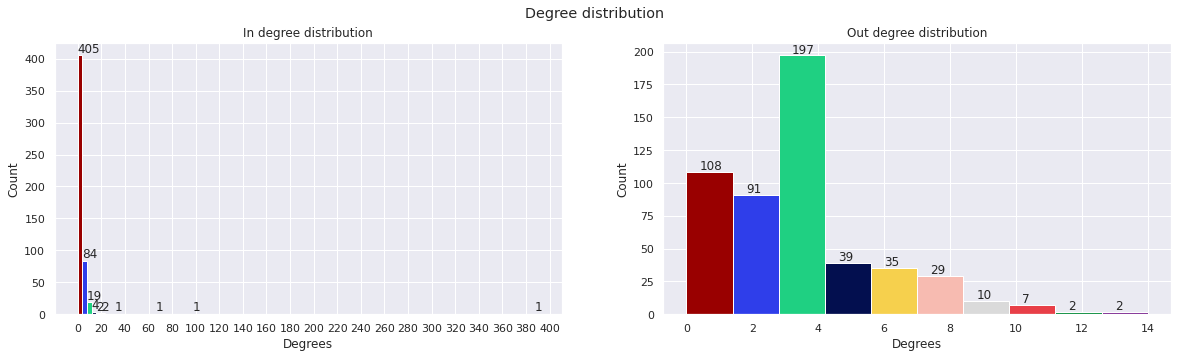

In [5]:
fig, (in_ax, out_ax) = plt.subplots(1, 2, **default)
fig.suptitle("Degree distribution")

in_degrees = dict(GCC.in_degree()).values()
out_degrees = dict(GCC.out_degree()).values()

counts, bins, bars = in_ax.hist(in_degrees, bins=100)
in_ax.set_title("In degree distribution")
in_ax.set_xlabel("Degrees")
in_ax.set_ylabel("Count")
in_ax.set_xticks(np.arange(0, 420, step=20))

bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)
col *= 10


for c, p in zip(col, bars):
  plt.setp(p, 'facecolor', cmap(c))

for c, b in zip(counts, bins):
    if c > 0: in_ax.text(b, c+5, f"{c:.0f}")
      
      
counts, bins, bars = out_ax.hist(out_degrees)
out_ax.set_title("Out degree distribution")
out_ax.set_xlabel("Degrees")
out_ax.set_ylabel("Count")

bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)


for c, p in zip(col, bars):
  plt.setp(p, 'facecolor', cmap(c))

for c, b in zip(counts, bins):
  if c > 0: out_ax.text(b+.4, c+2, f"{c:.0f}")

plt.show()

## Comment on the in- and out-degree distributions 

The first apparent difference that one can see is that for the in-degree distribution, there is one notable outlier that skews the plot a lot (Link). To fully explain the differences, it's necessary to use more bins in the in-degree distribution plot.

Once that is done, it is clear that most characters have an in-degree very small (between 0 and 5). That does make sense because most secondary characters do not have external references in other character wikis, only the main characters. The Link outlier makes sense, too, as are the main characters, and most wiki pages reference him.

On the other hand, the out-degree is more spread, without outliers. Most characters make a few references in their wiki to other characters, and only a tiny percentage of them have a lot of out-degree links.

## Exponent of the degree distributions

In [6]:
in_degree = [d for n, d in GCC.in_degree() if d > 0]
out_degree = [d for n, d in GCC.out_degree() if d > 0]

results_in = powerlaw.Fit(in_degree, xmin=1)
results_out = powerlaw.Fit(out_degree, xmin=1)

print(f"Exponent of the degree distribution for the in-degree:\t {results_in.alpha}")
print(f"Exponent of the degree distribution for the out-degree:\t {results_out.alpha}")

Exponent of the degree distribution for the in-degree:	 2.0968769070278466
Exponent of the degree distribution for the out-degree:	 1.9179618614179939


## Comment on the exponent of the degree distribution

As shown in the previous calculations with the `powerlaw` package, the degree exponent for the in-degree distribution is slightly higher than `2.09`, which would fit in the *Scale-Free Regime*. That means that this degree distribution follows a scale-free distribution.

Meanwhile, the degree exponent for the out-degree distribution is under `2.0`, which belongs to the *Anomalous Regime*. That means that the number of links connected to the largest hub grows faster than the size of the network. So eventually, with more nodes, it would become a scale-free distribution.

## Degree distribution and random network comparison

In [7]:
num_nodes = len(GCC.nodes)
prob_edge = (2 * len(GCC.edges)/num_nodes)/(num_nodes - 1)

random_g = nx.generators.random_graphs.erdos_renyi_graph(n=num_nodes, p=prob_edge)
print(f"Random network generated with {len(random_g.nodes)} nodes and {len(random_g.edges)} links")

Random network generated with 520 nodes and 1800 links


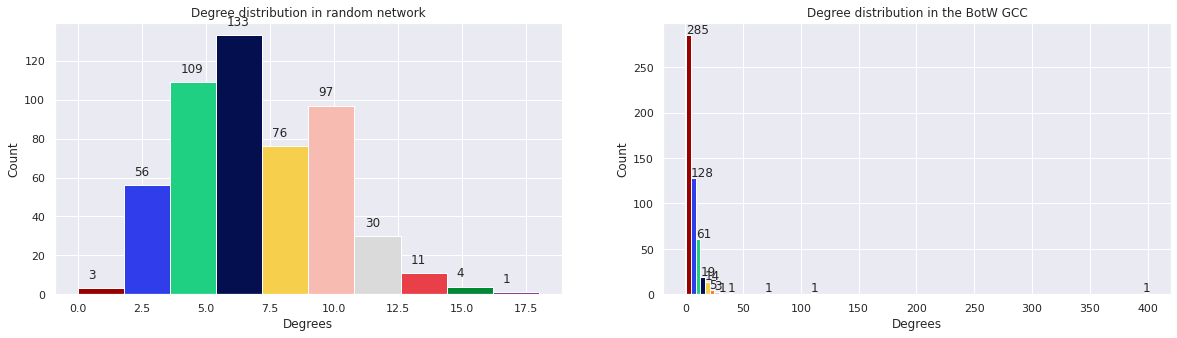

In [8]:
fig, (rand_ax, gcc_ax) = plt.subplots(1, 2, **default)
random_degrees = dict(random_g.degree()).values()
GCC_degrees = dict(GCC.degree()).values()

counts, bins, bars = rand_ax.hist(random_degrees)
rand_ax.set_title("Degree distribution in random network")
rand_ax.set_xlabel("Degrees")
rand_ax.set_ylabel("Count")

bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)


for c, p in zip(col, bars):
  plt.setp(p, 'facecolor', cmap(c))

for c, b in zip(counts, bins):
    if c > 0: rand_ax.text(b+.4, c+5, f"{c:.0f}")

counts, bins, bars = gcc_ax.hist(GCC_degrees, bins=100)
gcc_ax.set_title("Degree distribution in the BotW GCC")
gcc_ax.set_xlabel("Degrees")
gcc_ax.set_ylabel("Count")

bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)
col *= 10


for c, p in zip(col, bars):
  plt.setp(p, 'facecolor', cmap(c))

for c, b in zip(counts, bins):
    if c > 0: gcc_ax.text(b, c+2, f"{c:.0f}")

## Comment on degree distribution and random network comparison

As expected, the degree distribution in a random network follows a Poisson distribution. In contrast, the degree distribution of the BotW GCC follows a scale-free distribution, or a least is much closer to that distribution. 

# Exercise 1.b
First, we create the placement of nodes using the forceatlas2 algorithm. Then we visualize and reflect on the result.

In [9]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=4.0,
                        strongGravityMode=True,
                        gravity=0.1,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(GCC, pos=None, iterations=500)

100%|█████████████████████████████████████████| 500/500 [00:35<00:00, 14.11it/s]

BarnesHut Approximation  took  3.74  seconds
Repulsion forces  took  29.58  seconds
Gravitational forces  took  0.32  seconds
Attraction forces  took  0.68  seconds
AdjustSpeedAndApplyForces step  took  0.83  seconds


## Visualization

```
  Color of the node   -> Role
  Size of the node    -> Degree
  Color of the border -> Race

```

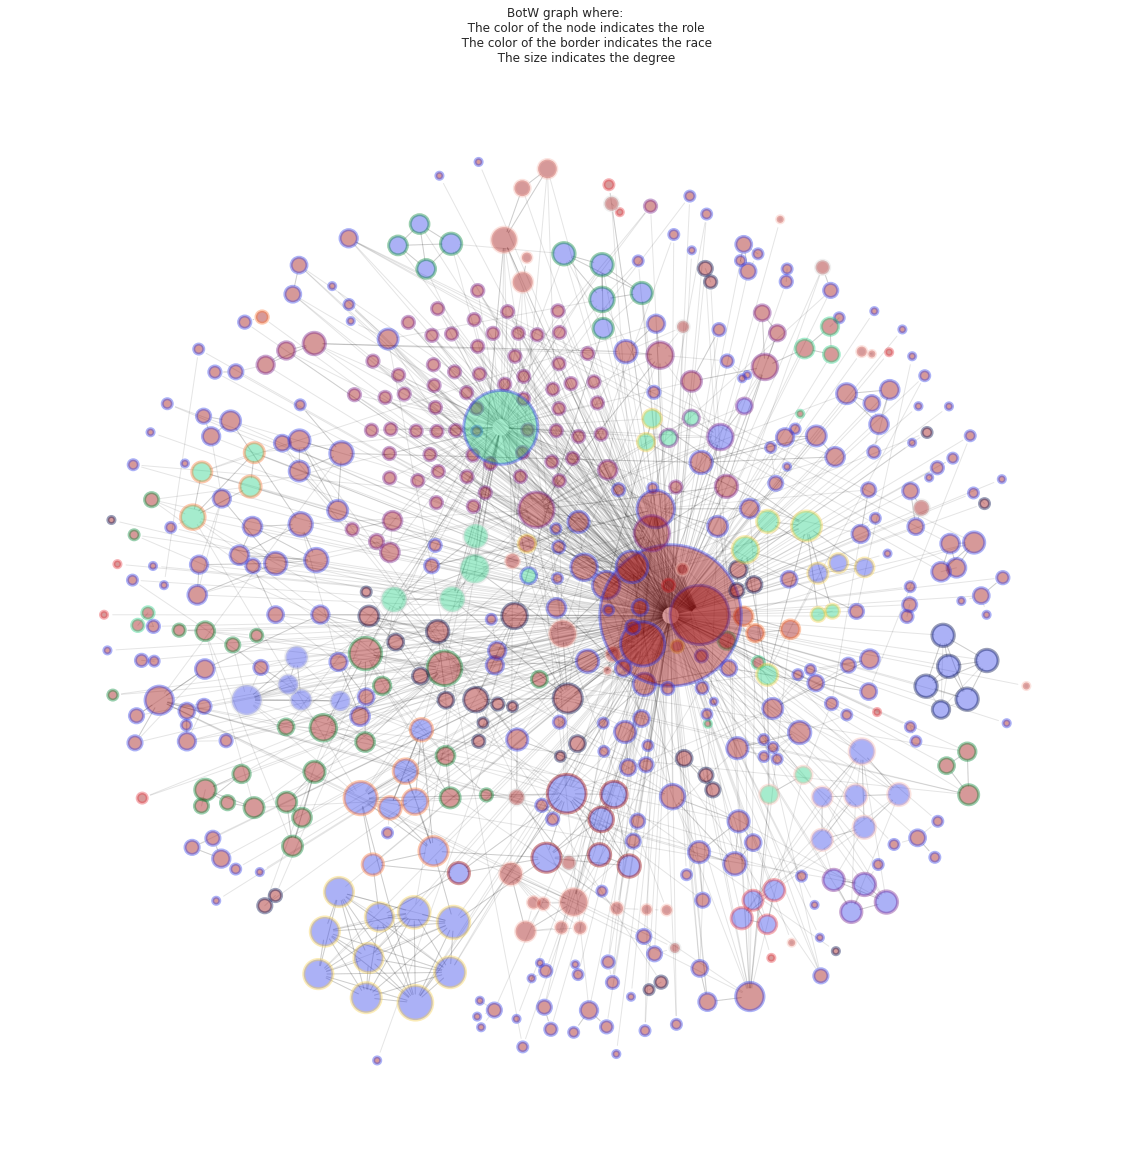

In [10]:
plt.figure(**big_plot)
plt.plot()

color_role = dict(
  Ally  = DTU_COLORS_HEX["dtured"],
  Enemy = DTU_COLORS_HEX["blue"],
  Boss  = DTU_COLORS_HEX["brightgreen"]
)

color_race = {
  "Hylian"         : DTU_COLORS_HEX["blue"], 
  "Horse"          : DTU_COLORS_HEX["brightgreen"],
  "Goron"          : DTU_COLORS_HEX["navyblue"],
  "Human"          : DTU_COLORS_HEX["yellow"],
  "Dragon"         : DTU_COLORS_HEX["orange"], 
  "Rito"           : DTU_COLORS_HEX["pink"],
  "Unknown"        : DTU_COLORS_HEX["grey"],
  "Korok"          : DTU_COLORS_HEX["red"],
  "Zora"           : DTU_COLORS_HEX["green"],
  "Sheikah"        : DTU_COLORS_HEX["purple"],
  "Gerudo"         : DTU_COLORS_HEX["blue"],
  "Great Fairy"    : DTU_COLORS_HEX["brightgreen"],
  "Ancient Orb"    : DTU_COLORS_HEX["navyblue"],
  "Sand Seal"      : DTU_COLORS_HEX["yellow"],
  "Dog"            : DTU_COLORS_HEX["orange"],
  "Bokoblin"       : DTU_COLORS_HEX["dtured"],  
  "Lizalfos"       : DTU_COLORS_HEX["yellow"],
  "Moblin"         : DTU_COLORS_HEX["orange"],
  "Wizzrobe"       : DTU_COLORS_HEX["pink"],
  "Lynel"          : DTU_COLORS_HEX["grey"],
  "Chuchu"         : DTU_COLORS_HEX["red"],
  "Guardian"       : DTU_COLORS_HEX["green"],
  "Keese"          : DTU_COLORS_HEX["purple"],
  "Octorok"        : DTU_COLORS_HEX["navyblue"],
  "Talus"          : DTU_COLORS_HEX["yellow"],
  "Hinox"          : DTU_COLORS_HEX["orange"],
  "Molduga"        : DTU_COLORS_HEX["pink"]
}

 

scale = 50

node_info = list()
labels = dict()

for node, node_data in list(GCC.nodes(data=True)):
  
  color = color_role[node_data["role"]]
  size = GCC.degree(node)*scale
  border_color = color_race[node_data["race"]]
  
  
  node_info.append((node, color, size, border_color))

nx.draw_networkx_nodes(GCC,
                       positions,
                       edgecolors  = [x[3] for x in node_info],
                       linewidths  = 3,
                       node_color  = [x[1] for x in node_info],
                       node_size   = [x[2] for x in node_info]  ,
                       alpha       = 0.4
                      )

nx.draw_networkx_edges(GCC,
                       positions,
                       edge_color  = "black",
                       arrowstyle  = "-",
                       alpha       = 0.1
                      )  
plt.axis("off")
plt.title("BotW graph where:\n \
          The color of the node indicates the role\n \
          The color of the border indicates the race\n \
          The size indicates the degree")
plt.show()

## Comment on visualization

As expected, the biggest node is 'Link', as is the one most connected. Other significant nodes that can be seen are 'Calamity Ganon' or 'Princess Zelda', also central characters.

Another thing that can be seen quite clearly with the graph is that bosses and enemies tend to be referenced together, as they have many links between them. The same happens with the allies. Of course, some nodes that are allies are connected to enemies.

About the connections between nodes, we can see that most nodes are connected to other nodes of the same race, which makes sense, as, in the game, the character of the same race are in the same areas, so they make references to other characters of the same place.


*Side note: The colouring by race is not perfect, as some colours are repeating. This is because we wanted to do something visually nice and use the [DTU-colorscheme](https://www.designguide.dtu.dk/standard-design-basics#standard-user-color-banner). The colours we feel, do still help in the general visualization*

# 2. Wordclouds
This part will explain the process of constructing the wordclouds. The construction of the wordclouds includes three steps: fetching the descriptions, preprocessing the descriptions and calculating TF and IDF.

## Fetching the descriptions
This is mostly solved in the same way as previous. For each character name, the description is fetched using the API and stored in a .txt file.

## Preprocessing the descriptions
In this step, first, the headers are removed denoted with the `=`-symbol.

Because it seemed more straightforward to use regex to remove punctuation, this is done as well.

Then some of the muscle power 💪 from nltk is used to remove all English stopwords, the names of all known characters, and the words are lemmatized.

## TF and IDF
Following the formulas of TF and IDF, the values are calculated for each term and stored in a pd.DataFrame. This is done to use vectorization to speed up the process a bit.

In [11]:
# Downloading Descriptions for each character

df = pd.read_csv("Characters.csv")
txt_path = "./Descriptions"

baseurl = "https://zelda.fandom.com/api.php?"
content = "action=query&titles={name}&prop=extracts&exlimit=1&explaintext&format=json&indexpageids=true"

def download_txt(row):
    name = row.Name.replace(" ", "_")
    quoted_name = urllib.parse.quote_plus(name)
    url = baseurl + content.format(name=quoted_name)

    data = requests.get(url).json()
    extract = list(data["query"]["pages"].values())[0]["extract"]
    
    with open(f"{txt_path}/{row.Name}.txt", "w") as f:
        f.write(str(extract.encode(encoding="utf-8", errors="xmlcharrefreplace")))

download = False
if download: df.apply(download_txt, axis=1)

In [12]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pheithar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pheithar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
# Processing each character description removing, tokenizing and lemmatizing.

raw_path = "Descriptions/"
processed_path = "ProcessedDescriptions/"
names = df.Name.values

tokenizer = nltk.tokenize.WordPunctTokenizer()
wnl = nltk.WordNetLemmatizer()

def preprocess_zelda_descriptions(row):
    filename = row.Name + ".txt"
    txt = open(raw_path + filename, "r").read()[2:-1]
    txt.encode('latin1').decode("utf-8")

    txt = re.sub("=+.*?=+", " ", txt) # Removes header
    txt = re.sub(r"\\n|\.|,|\\", " ", txt) # Remove signs

    token = tokenizer.tokenize(txt)
    all_words = [x.strip().lower() for x in token]

    stop_words = nltk.corpus.stopwords.words("english") # Stopwords
    stop_words += [".", ",", "'", "\"", "/", ")", "(", "*", "\*"] # Some signs were not removed through regex
    stop_words += [x.lower() for x in names] # Names

    filtered = [w for w in all_words if w not in stop_words]

    lemmatized = [wnl.lemmatize(w) for w in filtered]

    with open(processed_path + filename, "w") as f:
        f.write(" ".join(lemmatized))

process = True
if process: df.apply(preprocess_zelda_descriptions, axis=1)

In [14]:
# Calculating TF, IDF and TF-IDF for each lemmatized word in each race

races = {}

def TF(term, text: nltk.Text) -> float:
    return text.count(term) / len(text)

def IDF(terms, wlist: nltk.corpus.PlaintextCorpusReader) -> pd.DataFrame:
    counts = [[term, 0] for term in terms]

    for file_id in wlist.fileids():
        txt = wlist.raw(file_id).split(" ")
        for row in counts:
            if row[0] in txt: row[1] += 1

    i_df = pd.DataFrame(counts, columns=["Term", "IDF"])
    i_df["IDF"] = np.log2(len(wlist.fileids())/i_df["IDF"])

    return i_df

for race in tqdm(df.Race.unique().tolist()):
    filenames = [name + ".txt" for name in df[df.Race==race].Name]
    wlist = nltk.corpus.PlaintextCorpusReader(processed_path, filenames)

    terms = set(wlist.words())

    text = nltk.Text(wlist.words())
    tfs = [[term, TF(term, text)] for term in terms]
    tdf = pd.DataFrame(tfs, columns=["Term", "TF"])

    idf = IDF(terms, wlist)
    
    races[race] = {}
    races[race]["pd"] = pd.merge(tdf, idf, on="Term")
    races[race]["wlist"] = wlist

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

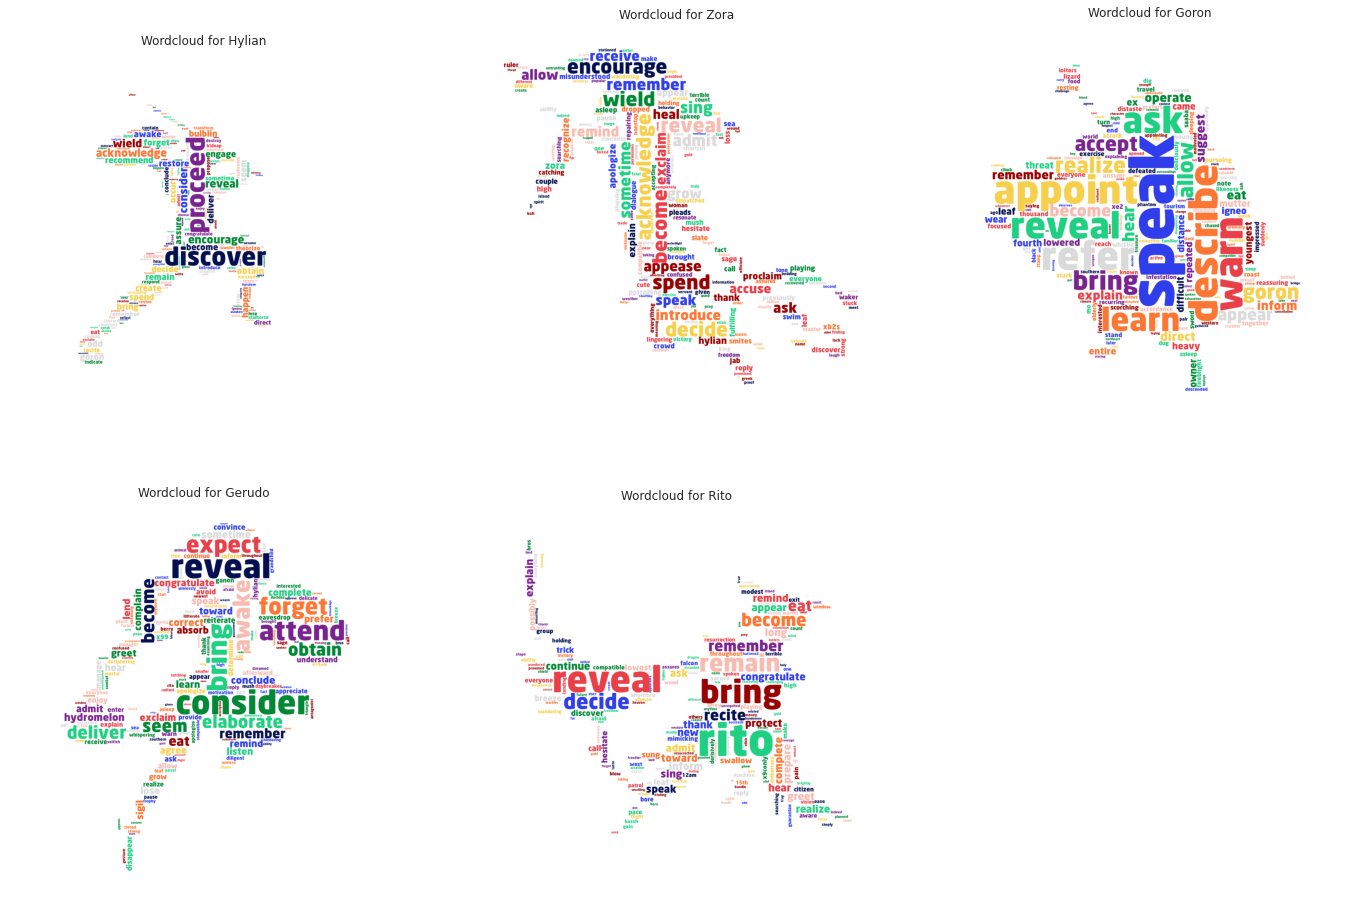

In [15]:
# Generating wordclouds

race_order  = [
    "Hylian", 
    "Zora", 
    "Goron", 
    "Gerudo", 
    "Rito"
]

rows = 2
cols = 3
cloud_size = 1000


fig, axs = plt.subplots(rows, cols, figsize=(24, 16))
for ax, race in tqdm(zip(axs.flatten(), race_order), total=5):
    race_df = races[race]["pd"]
    
    # Repeat each word int(IDF)-number of times
    #words = [[x.Term] * int(x.IDF) for x in race_df.itertuples()] 
    words = [[x.Term] for x in race_df.itertuples()] 
    
    # Flatten the list of lists
    flattened_words = [item for subl in words for item in subl] 

    # Join all the words
    joined_words = " ".join(flattened_words)

    mask = plt.imread(f"./images/{race}.jpg")

    wcloud = wordcloud.WordCloud(
        background_color="white",
        width=cloud_size,
        height=cloud_size,
        mask=mask,
        font_path="./NeoSans Black.otf",
        colormap=cmap
    ).generate(joined_words)

    ax.imshow(wcloud)
    ax.axis("off")
    ax.set_title(f"Wordcloud for {race}")
plt.axis("off")
plt.savefig("./images/wordcloud.jpg", dpi=300)
plt.show()

# Results of the wordclouds

![background](./images/bg.jpg)

In the wordclouds it becomes apparent that the different races in Zelda has different words describing their actions. For instance we see that the people of Goron seem talkative and the people of Gerudo seem Sneaky. Looking at the wordcloud for Rito it would maybe also suggest, that they are an NPC giving quests to link, as some of the words from it are: inform, explain, remind, and prepare, which we intiuitively intepret as common words in video games when giving quests to the player. An example would be "Name of someone from Rito" informed/explained/reminded/prepared something to Link.

# 3. Communities and TF-IDF
## Explanation of the Louvain Algorithm
The Louvain algorithm consists of two steps: Modularity Optimization and Community Aggregation. 

In the modularity optimization step, the algorithm randomly orders all nodes in the network. From here, it removes and inserts each node in different communities until no significant increase in modularity is seen.

In the second step of community aggregation, the algorithm merges all nodes belonging to the same community into one node. This step can create self-loops. These loops are collapsed into the same giant nodes.

## Choice of community algorithm
For this exercise, we chose to use the Louvain algorithm to identify communities; as we from classes had an intuition about how it worked and had seen in previous exercises, its result seemed promising.

## Preliminary code
Below we create the communities and TF, IDF, and TF-IDF ratings for each community. First, we plot the community in nx to get a visual sense of the data. Then calculations,

In [16]:
# Transforming GCC to non-directed graph
UGCC = GCC.to_undirected()

# Using Louvain to find the best communities
partition = community.best_partition(UGCC)

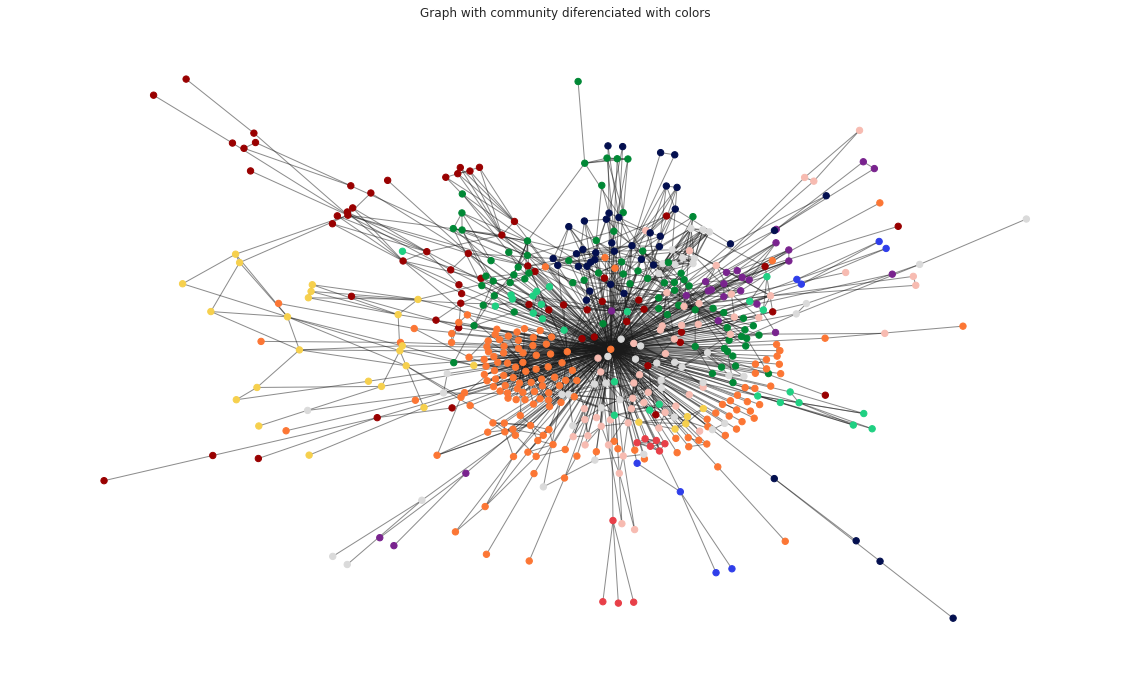

In [17]:
plt.figure(figsize=(20, 12))

pos = nx.spring_layout(UGCC)
# color the nodes according to their partition
# cmap = matplotlib.colors.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(UGCC, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(UGCC, pos, alpha=0.5)

ax = plt.gca()
ax.set_facecolor('white')
plt.axis("off")
plt.title("Graph with community diferenciated with colors")
plt.show()

In [18]:
# Code for constructing dicts with information from the partition,
# and for calculating modularity for a community given a graph

def construct_communities(partition, G):
  communities = dict()

  for node_name in G.nodes():
    key = partition[node_name]
    communities[key] = communities.get(key, [])
    communities[key].append(node_name)
  
  return communities

def modularity(communities, graph):
  modularity = 0
  for com in communities:
    Lc = len(graph.edges(communities[com]))
    L = len(graph.edges)
    kc = sum(x[1] for x in list(graph.degree(communities[com])))
    
    modularity += Lc/L - (kc/(2*L))**2
  return modularity

communities = construct_communities(partition, UGCC)
mod = modularity(communities, UGCC)

# Setting the dictionary keys to top3 names, as specified in exercise
for key, com in dict(communities).items():
  top3 = sorted([name for name in com], key = lambda x: UGCC.degree(x), reverse=True)[:3]
  names = "_".join([x.replace(" ", "-") for x in top3])

  # Adding top3 as new name, and deleting previous key
  communities[names] = com
  del communities[key]


## Number of communities and modularity

In [19]:
print("Number of communities:", len(set(partition.values())))
print("Modularity:", mod)

Number of communities: 24
Modularity: 1.1670557009357942


## Distribution of community sizes

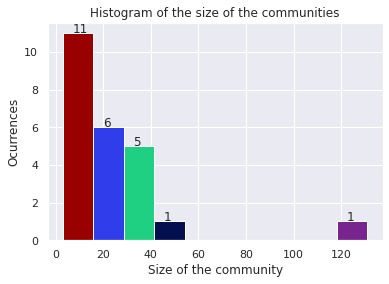

In [20]:
counts, bins, bars = plt.hist([len(x) for x in communities.values()])

bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)


for c, p in zip(col, bars):
  plt.setp(p, 'facecolor', cmap(c))

for c, b in zip(counts, bins):
    if c > 0: plt.text(b+4, c+.05, f"{c:.0f}")
      
plt.title("Histogram of the size of the communities")
plt.xlabel("Size of the community")
plt.ylabel("Ocurrences")
plt.show() # Fix colors

## Exercises on the top 5 of communities

### Methods for computing TF and IDF
**TF** is calculated by the number of times a term is mentioned in a text and dividing it by the number of words. As this solution did not seem demanding, this solution is relatively trivial. Because of the need to multiply TF and IDF in TF-IDF, we put the values into a data frame, as vectorized calculations are way faster than conventional loops in python.

**IDF** Is calculated using the formula $ln(\frac{Num\_documents}{Num\_documents\_word\_in})$. Because this seemed a little more intensive, the counts are added to a data frame, and the logarithmic and division operation is done using vectorized calls with pandas.

**TF-IDF** Is calculated using the formula $TF*IDF$. We multiply the two columns of the previous data frame **TF** and **IDF** to speed things up.


In [21]:
# Calculating TF, IDF and TF-IDF for communities

sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)
largest = sorted_communities[:5]

tfidf_coms = {}
for (key, names) in largest:
    filenames = [name + ".txt" for name in names]
    wlist = nltk.corpus.PlaintextCorpusReader(processed_path, filenames)
    
    terms = set(wlist.words())
    text = nltk.Text(wlist.words())
    
    tfs = [[term, TF(term, text)] for term in terms]
    tdf = pd.DataFrame(tfs, columns=["Term", "TF"])
    idf = IDF(terms, wlist) # Referencing a previous function in wordclouds

    temp_df = pd.merge(tdf, idf, on="Term")
    temp_df["TFIDF"] = temp_df.TF * temp_df.IDF

    tfidf_coms[key] = temp_df

## Top 5 words for each community according to TF

In [22]:
print("Top 5 according to TF")
for com, frame in tfidf_coms.items():
    print("Community:", com)
    display(frame.sort_values(by="TF", ascending=False).head(5)[["Term", "TF"]].style.hide_index())
    print()

Top 5 according to TF
Community: Link_Calamity-Ganon_Hylia


Term,TF
shrine,0.026819
monk,0.015209
sheikah,0.013083
wild,0.011774
breath,0.011229



Community: Riju_Traysi_Vilia


Term,TF
gerudo,0.043831
town,0.024676
say,0.013115
speaks,0.012597
tell,0.010699



Community: Urbosa_Daruk_Kass


Term,TF
ganon,0.017682
beast,0.012568
divine,0.009791
zelda,0.009499
goron,0.009353



Community: Bokoblin_Moblin_Lynel


Term,TF
moblins,0.014519
bokoblins,0.014264
-,0.012481
blue,0.009424
golden,0.008660



Community: Purah_Impa_Robbie


Term,TF
sheikah,0.009652
village,0.008763
zelda,0.007747
asks,0.006604
yiga,0.006477


## Top 5 words for each community according to TF-IDF

In [23]:
print("Top 5 according to TF-IDF")
for com, frame in tfidf_coms.items():
    print("Community:", com)
    display(frame.sort_values(by="TFIDF", ascending=False).head(5)[["Term", "TFIDF"]].style.hide_index())
    print()

Top 5 according to TF-IDF
Community: Link_Calamity-Ganon_Hylia


Term,TFIDF
zelda,0.036766
sword,0.023728
shrine,0.021066
hero,0.017804
hyrule,0.017504



Community: Riju_Traysi_Vilia


Term,TFIDF
volume,0.014888
kara,0.013342
stable,0.010512
tell,0.009981
bazaar,0.009673



Community: Urbosa_Daruk_Kass


Term,TFIDF
ganon,0.028026
korok,0.018336
zelda,0.017554
sister,0.014567
brother,0.013621



Community: Bokoblin_Moblin_Lynel


Term,TFIDF
moblins,0.031504
lynels,0.022386
old,0.018436
bokoblins,0.016688
-,0.013510



Community: Purah_Impa_Robbie


Term,TFIDF
monk,0.016276
maz,0.014493
koshia,0.014493
zelda,0.014316
kohga,0.012480


# 4. Sentiment of communities
First we do the sentiment analysis of characters. This is done in the LabMT and Vader section, named after the lexicons. Then we look at the histograms, happiest and saddest characters, and the community analysis.

## LabMT

In [24]:
dialogue = json.loads(open("Dialogue/CharactersDialogue.json", "r").read())
pretty_dialogue = {}

wnl = nltk.WordNetLemmatizer()
wpt = nltk.WordPunctTokenizer()

# We're not removing punctuation, as if the symbol, is not present
# in LabMT, we will not score it.
for name, word_list in dialogue.items():
    lemmatized = wnl.lemmatize(" ".join(word_list))
    lower = lemmatized.lower()
    tokens = wpt.tokenize(lower)
    pretty_dialogue[name] = tokens

In [25]:
# Sentimenting
LabMT = pd.read_csv("./Wordlist/pone.0026752.s001.txt", delimiter="\t", skiprows=3)
LabMT_sentiments = {}

lab_sentiments = {}
for name, tokens in tqdm(pretty_dialogue.items()):
    freq = nltk.FreqDist(tokens)
    nominator, denominator = 0, 0

    for word in freq.keys():
        if word in LabMT.word.values:
            fk = freq.get(word)
            vk = LabMT[LabMT.word == word].happiness_average.values[0]

            nominator += vk * fk
            denominator += fk
    
    if denominator > 0:
        lab_sentiments[name] = nominator/denominator

  0%|          | 0/475 [00:00<?, ?it/s]

## VADER

In [26]:
VADER = SentimentIntensityAnalyzer()
VADER_sentiments = {}
for name, tokens in tqdm(dialogue.items()):
    VADER_sentiments[name] = VADER.polarity_scores(tokens)

  0%|          | 0/475 [00:00<?, ?it/s]

# Analysis of characters
First we show the histograms, then the top 10 happiest and saddest according to LabMT and Vader

[-0.996   -0.79641 -0.59682 -0.39723 -0.19764  0.00195  0.20154  0.40113
  0.60072  0.80031  0.9999 ] <BarContainer object of 10 artists>


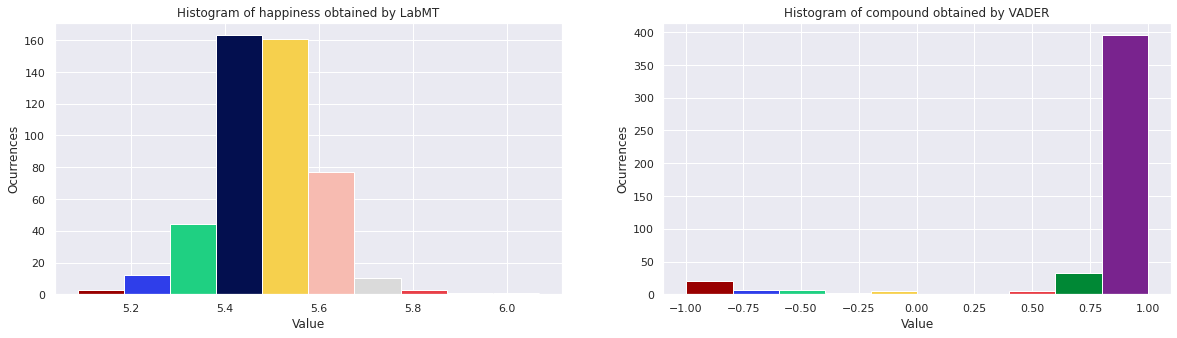

In [27]:
# Histogram
fig, (lab, vad) = plt.subplots(1, 2, **default)

counts, bins, bars = lab.hist(lab_sentiments.values())
lab.set_title("Histogram of happiness obtained by LabMT")
lab.set_xlabel("Value")
lab.set_ylabel("Ocurrences")

bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)


for c, p in zip(col, bars):
  plt.setp(p, 'facecolor', cmap(c))

counts, bins, bars = vad.hist([x["compound"] for x in VADER_sentiments.values()])
vad.set_title("Histogram of compound obtained by VADER")
vad.set_xlabel("Value")
vad.set_ylabel("Ocurrences")

bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)


for c, p in zip(col, bars):
  plt.setp(p, 'facecolor', cmap(c))

  
print(bins, bars)
plt.show()

In [28]:
# Top 10
lab_sentiment_sorted = sorted(lab_sentiments.items(), key=lambda x: x[1], reverse=True)
vader_compound_sorted = sorted(VADER_sentiments.items(), key=lambda x: x[1]["compound"], reverse=True)

num = 10

print("Happiest lab:\n", "\n ".join([str(x) + ": " + str(y)
                                     for x, y in lab_sentiment_sorted[:num]])) # Happiest lab
print("\nSaddest lab:\n", "\n ".join([str(x) + ": " + str(y)
                                      for x, y in lab_sentiment_sorted[-num:]])) # Saddest lab
print("\nHappiest vader:\n", "\n ".join([str(x) + ": " + str(y["compound"])
                                         for x, y in vader_compound_sorted[:num]])) # 
print("\nSaddest vader:\n", "\n ".join([str(x) + ": " + str(y["compound"])
                                        for x, y in vader_compound_sorted[-num:]]))


Happiest lab:
 Zooki: 6.068571428571429
 Kinov: 5.966666666666668
 Narah: 5.837431192660549
 Tasho: 5.8296
 Shamae: 5.808235294117649
 Kula: 5.765384615384615
 Toren: 5.737701149425289
 Chessica: 5.733129770992369
 Notts: 5.703015873015873
 Kayden: 5.69268221574344

Saddest lab:
 Laine: 5.247499999999999
 Sudrey: 5.242743362831858
 Flaxel: 5.237540983606562
 Bargoh: 5.215220588235297
 Palme: 5.200645161290322
 Strade: 5.1944690265486715
 Walton: 5.19
 Kotta: 5.176074074074074
 Kenyo: 5.175593220338983
 Aya: 5.087692307692309

Happiest vader:
 Nazbi: 0.9999
 Lonni: 0.9999
 Paya: 0.9999
 Baddek: 0.9998
 Cambo: 0.9998
 Galli: 0.9998
 Brokka: 0.9998
 Daruk: 0.9997
 Mipha: 0.9997
 Stamm: 0.9997

Saddest vader:
 Russ: -0.9555
 Geggle: -0.9564
 Kaifa: -0.9639
 Hoz: -0.9725
 Kotts: -0.9797
 Kotta: -0.9832
 Strade: -0.9854
 Dayto: -0.9917
 Rik: -0.9941
 Princess Zelda: -0.996


# Analysis of communities

In [29]:
# Calculating average score of LabMT: lab_avg... and VADER: vad_avg...
lab_avg_communities = {}
for name, characters in communities.items():
    lab_avg_communities[name] = sum([lab_sentiments[cname] 
                                    for cname in characters 
                                    if cname in lab_sentiments.keys()])/len(characters)
                                    
lab_avg_communities = {name: val for name, val in lab_avg_communities.items() if val != 0.0}

vad_avg_communities = {}
for name, characters in communities.items():
    vad_avg_communities[name] = sum([VADER_sentiments[cname]["compound"] 
                                    for cname in characters 
                                    if cname in VADER_sentiments.keys()])/len(characters)

vad_avg_communities = {name: val for name, val in vad_avg_communities.items() if val != 0.0}

## Happiest and saddest communities

In [30]:
# 3 Happiest
print("Happiest communities LabMT")
print("\n".join([str(x) + ": " + str(y) for x, y in sorted(lab_avg_communities.items(),
                                                           key = lambda x: x[1],
                                                           reverse=True)[:3]]))

print()
print("Happiest communities Vader")
print("\n".join([str(x) + ": " + str(y) for x, y in sorted(vad_avg_communities.items(),
                                                           key = lambda x: x[1],
                                                           reverse=True)[:3]]))

print()
print("Saddest communities LabMT")
print("\n".join([str(x) + ": " + str(y) for x, y in sorted(lab_avg_communities.items(),
                                                           key = lambda x: x[1],
                                                           reverse=True)[-3:]]))

print()
print("Saddest communities Vader")
print("\n".join([str(x) + ": " + str(y) for x, y in sorted(vad_avg_communities.items(),
                                                           key = lambda x: x[1],
                                                           reverse=True)[-3:]]))

Happiest communities LabMT
Armes_Cloyne_Numar: 5.585573195846489
Darton_Rensa_Shibo: 5.525412001518552
Amira_Azu_Nikki: 5.517542220630416

Happiest communities Vader
Armes_Cloyne_Numar: 0.9600000000000001
Darton_Rensa_Shibo: 0.9583999999999999
Ami_Izra_Yolero: 0.9255666666666666

Saddest communities LabMT
Kilton_Stone-Talus_Igneo-Talus: 1.9040776647149713
Monkton_Harry-(Breath-of-the-Wild)_Mary-(Breath-of-the-Wild): 1.7767359050445102
Princess-Zelda_Fire-Wizzrobe_Electric-Wizzrobe: 1.4529032521267664

Saddest communities Vader
Bokoblin_Moblin_Lynel: 0.2521083333333334
Princess-Zelda_Fire-Wizzrobe_Electric-Wizzrobe: 0.1575105263157895
Monkton_Harry-(Breath-of-the-Wild)_Mary-(Breath-of-the-Wild): -0.05756666666666666


In [31]:
lab_std = {}

lab_std = {name: (sum([(lab_sentiments[cname] - lab_avg_communities[name])**2 
                        for cname in characters 
                        if cname in lab_sentiments.keys()])/len(characters))**.5
                        for name, characters in communities.items()
                        if name in lab_avg_communities.keys()}
                        
vad_std = {name: (sum([(VADER_sentiments[cname]["compound"] - vad_avg_communities[name])**2 
                        for cname in characters 
                        if cname in VADER_sentiments.keys()])/len(characters))**.5
                        for name, characters in communities.items()
                        if name in vad_avg_communities.keys()}

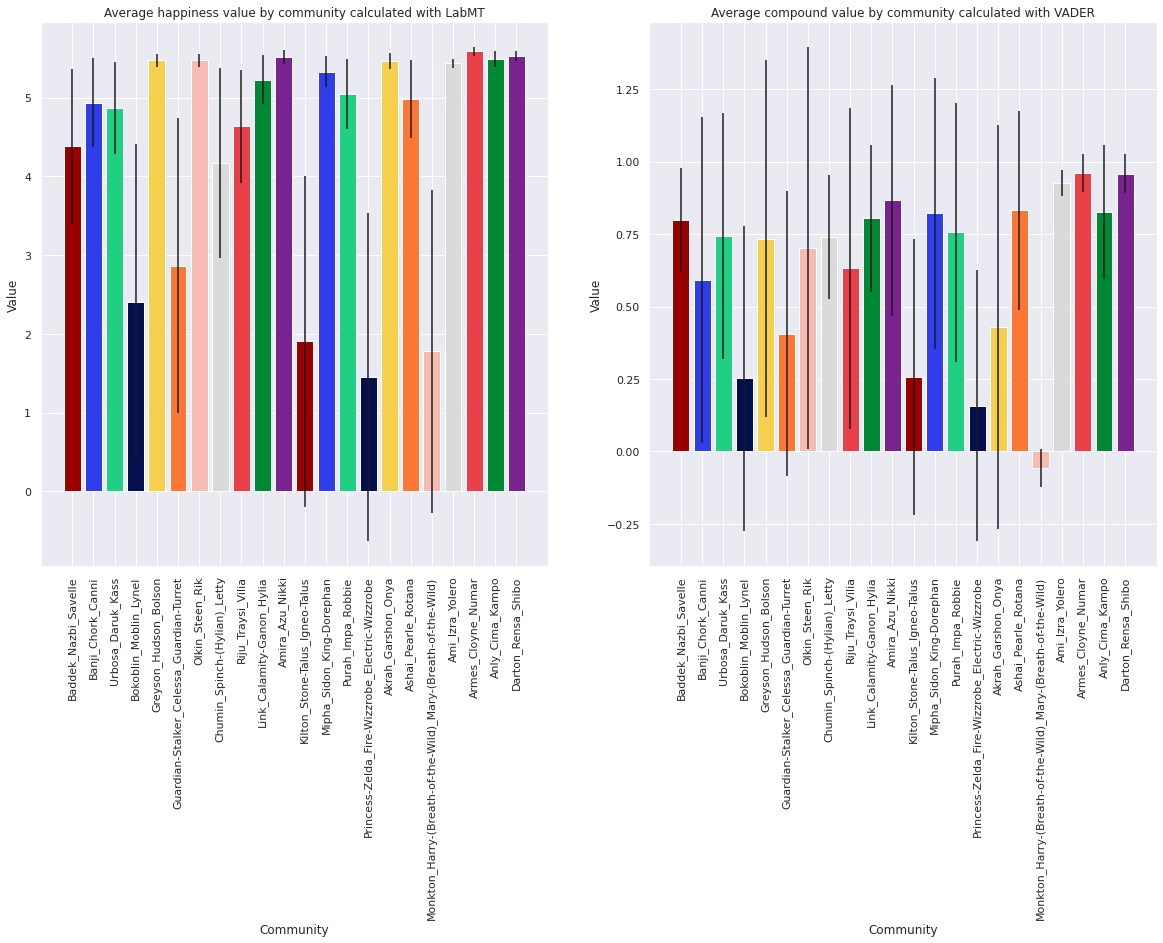

In [32]:
fig, (lab, vad) = plt.subplots(1, 2, figsize=(20, 10))

bars = lab.bar(lab_avg_communities.keys(), lab_avg_communities.values(), yerr=lab_std.values())

for tick in lab.get_xticklabels():
    tick.set_rotation(90)
lab.set_title("Average happiness value by community calculated with LabMT")
lab.set_xlabel("Community")
lab.set_ylabel("Value")

for c, p in zip(range(len(bars)), bars):
  plt.setp(p, 'facecolor', cmap(c%cmap.N))

bars = vad.bar(vad_avg_communities.keys(), vad_avg_communities.values(), yerr=vad_std.values())
for tick in vad.get_xticklabels():
    tick.set_rotation(90)
vad.set_title("Average compound value by community calculated with VADER")
vad.set_xlabel("Community")
vad.set_ylabel("Value")

for c, p in zip(range(len(bars)), bars):
  plt.setp(p, 'facecolor', cmap(c%cmap.N))
  
plt.show()

## Differences between LabMT and VADER

The main difference etween the two ways of obtaining text sentiments is that LabMT is a dictionary-based approach, while VADER is a rule-based approach.

What can be seen in the previous plots is that both methods analyse the texts in a similar way. If one community has a greater value in LabMT, it will probably have a bigger value in VADER, and viceversa. However, VADER sometimes has a few differneces, probably due the fact that uses the context, so probably in those cases the text had negatives or sentences that changed the value of the sentiment.

Another striking fact is that the `std` seems to be greater in VADER, and can be explained againd by the fact that it uses context, so probably more texts inside a community have different sentiment, and is able to display it properly, not like LabMT.


## Advantage of rule-based method

The main advantage in a rule based method, over discyionary-based approachs is that it, at least, makes an attemp on understanding the context, while the dictionary-based only look up the vale of each word in a table.

Using different rules it can change the value and sentiment of a sentence, or taking into account negatives or exclamation marks.

# Ending
Welcome to the other side, we hope you enjoyed your stay 😁